In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
albums = pd.read_csv('../data/raw/albums.csv',encoding='utf-8',index_col=0)
#Pick out only the albums that have been sold
albums = albums[pd.notnull(albums['median price sold'])]

In [3]:
#Define our cost measures
def get_mean_diff(y_test,y_pred):
    """Calculate the mean difference between test and prediction"""
    mean_diff = np.mean(abs(y_test - y_pred))
    return mean_diff

def get_score(y_test, y_pred):
    """Calculate the R^2 score from two numpy array inputs, using a guess of the median as a benchmark"""
    u = sum((y_test - y_pred)**2)
    v = sum((y_test - np.mean(y_test))**2)
    R_sq = 1 - u/v
    return R_sq

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

#Define our predicting algorithm
def get_random_forest_predictions(new_albums, predictors):
    """Predict the price of each recors in albums from the features in predictors, using a random forest regressor"""

    #Do a random forest regression
    alg = RandomForestRegressor(min_samples_leaf = 3, n_estimators = 100)

    #Split the data into 10 subsets
    kf = KFold(new_albums.shape[0], n_folds = 10, random_state = 1)
    predictions = []
    scores = []

    #Train and predict
    for train, test in kf:
        X_train = (new_albums[predictors].iloc[train,:])
        y_train = new_albums['median price sold'].iloc[train]
        #Scale all the features
        scaler = StandardScaler().fit(X_train)
        X_train_transformed = scaler.transform(X_train)
        alg.fit(X_train_transformed, y_train)
        X_test = (new_albums[predictors].iloc[test,:])
        y_test = new_albums['median price sold'].iloc[test]
        test_predictions = alg.predict(scaler.transform(X_test))
        predictions.append(test_predictions)

    predictions = np.concatenate(predictions,axis = 0)
    #If anything is predicted a negative price, set this to zero
    predictions[predictions<0] = 0
    
    return predictions

Before adding any more features, let's check the performance with the initial set.

In [5]:
#Use the following predictors
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want']

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Random forest regression on initial features'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

Random forest regression on initial features gives £19.64 mean difference and 0.3423 score


Let's monitor how these (hopefully) improve as we add more features.

In [6]:
mean_diff_each_step = [mean_diff]
score_each_step = [score]
each_step = ['Initial features']

## Year of release

This should have a large bearing on the price, but the years of some releases are unknown. Let's make some assumptions about these to generate the feature.

In [7]:
#Convert the known years to integers
albums['integer year'] = [int(year[-4:]) if not pd.isnull(year) else year for year in albums['year']]

#For the unknown years
for index in albums[albums['year'].isnull()].index:
    ave_artist_year = np.round(albums.ix[albums['artist'] == albums.ix[index,'artist'],'integer year'].mean())
    ave_label_year = np.round(albums.ix[albums['label'] == albums.ix[index,'label'],'integer year'].mean())
    #If the artist has released other albums, take the year to be the artist's mean
    if not pd.isnull(ave_artist_year):
        albums.ix[index,'integer year'] = ave_artist_year
    #Otherwise if the label has released other albums, take the year to be the label's mean
    elif not pd.isnull(ave_label_year):
        albums.ix[index,'integer year'] = ave_label_year
    #Otherwise set the year to be the mean
    else:
        albums.ix[index,'integer year'] = albums['integer year'].mean()

In [8]:
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year']

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Random forest regression with year added'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

mean_diff_each_step.append(mean_diff)
score_each_step.append(score)
each_step.append('Year of release')

Random forest regression with year added gives £18.29 mean difference and 0.4012 score


So knowing the year helps a lot.

## Average rating

A lot of releases also have a rating given by users.

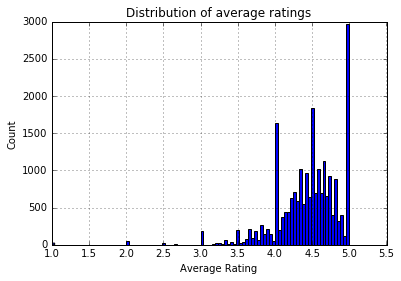

In [9]:
albums[~albums['average rating'].isnull()]['average rating'].hist(bins=100)
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.title('Distribution of average ratings');

In [10]:
for i in range(1,6):
    print(str(i) + '* rated albums have mean price £{0:.2f}'.format(albums.ix[(albums['average rating'] <= i)
                                                                               & (albums['average rating'] > i-1),
                                                                              'median price sold'].mean()))
print('Unrated albums have mean price £{0:.2f}'.format(albums.ix[albums['average rating'].isnull(),
                                                                       'median price sold'].mean()))

1* rated albums have mean price £38.79
2* rated albums have mean price £32.74
3* rated albums have mean price £36.40
4* rated albums have mean price £24.29
5* rated albums have mean price £37.11
Unrated albums have mean price £41.45


These are distributed towards the high end (as expected: we're looking at the most wanted records), but a higher rating does not necessarily correspond to a more expensive record.

Let's first try giving the unrated records the mean rating.

In [11]:
#If no rating is given, set it to be the average
albums['new rating'] = albums['average rating']
albums.ix[albums['new rating'].isnull(),'new rating'] = albums['new rating'].mean()

predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'new rating']

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Assuming the mean rating for those releases unrated'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

Assuming the mean rating for those releases unrated gives £18.33 mean difference and 0.4007 score


What about setting the unrated records to 0, or 6?

In [12]:
#If no rating is given, set it to be the average
albums['new rating'] = albums['average rating']
albums.ix[albums['new rating'].isnull(),'new rating'] = 0

predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'new rating']

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Assuming a rating of 0 for those releases unrated'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

Assuming a rating of 0 for those releases unrated gives £18.40 mean difference and 0.4018 score


In [13]:
#If no rating is given, set it to be the average
albums['new rating'] = albums['average rating']
albums.ix[albums['new rating'].isnull(),'new rating'] = 6

predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'new rating']

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Assuming a rating of 6 for those releases unrated'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

Assuming a rating of 6 for those releases unrated gives £18.33 mean difference and 0.4021 score


So assigning a 6 for the unrated items gives the best score.

In [14]:
albums.ix[albums['average rating'].isnull(),'average rating'] = 6

predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'average rating']

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

mean_diff_each_step.append(mean_diff)
score_each_step.append(score)
each_step.append('Average rating')

## Number of records 
Obviously all the records are LPs, but some may be double or even triple, let's add a feature of the number of records.

In [15]:
albums['format'].unique()

array(['Vinyl', '2 × Vinyl', '3 × Vinyl', '4 × Vinyl', '13 × Vinyl',
       '6 × Vinyl', 'Box Set', '10 × Vinyl', '5 × Vinyl', '14 × Vinyl',
       '7 × Vinyl', '9 × Vinyl', 'Box Set 6 × Vinyl', '11 × Vinyl',
       'Box Set 3 × Vinyl', 'Box Set 2 × Vinyl', '12 × Vinyl',
       'Box Set 10 × Vinyl', '16 × Vinyl', '18 × Vinyl'], dtype=object)

In [16]:
mean_diff = get_mean_diff(np.array(new_albums['median price sold'][new_albums['format']!='Vinyl']),
                          predictions[np.array(new_albums['format']!='Vinyl')])
score = get_score(np.array(new_albums['median price sold'][new_albums['format']!='Vinyl']),
                  predictions[np.array(new_albums['format']!='Vinyl')])
print('For boxsets we have £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff, score))

For boxsets we have £15.45 mean difference and 0.3669 score


So these boxsets are not being served well by the current predictor.

In [17]:
#If the format is 'Vinyl', assume one record
#Otherwise extract the number
albums['number of records'] = [1 if format_str == 'Vinyl' 
                               else [s for s in format_str.split() if s.isdigit()][0] if '×' in format_str
                               else None
                              for format_str in albums['format']]
#For the formats labelled just 'box set' look for the number of records in format details
for index in albums[albums['number of records'].isnull()].index:
    split_formats = albums.ix[index, 'format details'].split(';')
    num_records = [[s for s in format_str.split() if s.isdigit()][0] 
                   for format_str in split_formats if '×' in format_str]
    #Assume the maximum number is correct
    if len(num_records) != 0:
        albums.ix[index,'number of records'] = max(num_records)
    #If no number specified, assume 1
    else:
        albums.ix[index,'number of records'] = 1

In [18]:
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'average rating', 'number of records']

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Random forest with number of records added'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

mean_diff_each_step.append(mean_diff)
score_each_step.append(score)
each_step.append('Number of records')

Random forest with number of records added gives £18.00 mean difference and 0.4124 score


In [19]:
mean_diff = get_mean_diff(np.array(new_albums['median price sold'][new_albums['format']!='Vinyl']),
                          predictions[np.array(new_albums['format']!='Vinyl')])
score = get_score(np.array(new_albums['median price sold'][new_albums['format']!='Vinyl']),
                  predictions[np.array(new_albums['format']!='Vinyl')])
print('For boxsets we now have £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff, score))

For boxsets we now have £14.33 mean difference and 0.4546 score


So adding the number of records doesn't affect the score much, but offers a great improvement for boxsets themselves.

## Limited editions

Some records are described as 'limited edition' in either the format details or release notes. This could correlate with higher prices so let's add a binary variable for it.

In [20]:
#Pick out if limited edition is specified in format details or notes
albums.ix[albums['notes'].isnull(),'notes'] = ''
albums['limited edition'] = [(('Limited Edition' in albums.ix[index,'format details']) or 
                              ('Limited Edition' in albums.ix[index,'notes']))
                             for index in albums.index]

In [21]:
print('Limited edition albums have mean price £{0:.2f}'.format(albums.ix[albums['limited edition'] == 1,
                                                                         'median price sold'].mean()))
print('Non-limited edition albums have mean price £{0:.2f}'.format(albums.ix[albums['limited edition'] == 0,
                                                                         'median price sold'].mean()))

Limited edition albums have mean price £38.76
Non-limited edition albums have mean price £35.06


In [22]:
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'average rating', 'number of records', 'limited edition']

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Random forest with limited edition added'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

mean_diff_each_step.append(mean_diff)
score_each_step.append(score)
each_step.append('Limited edition')

Random forest with limited edition added gives £18.08 mean difference and 0.4018 score


Seems to make it worse.

## Reissues

Reissues are likely to be cheaper, while the original records that have been reissued will be more in demand, and so more expensive.  
Some reissues are specified in the format details and notes.

In [23]:
#Pick out if reissue is specified in format details or notes
albums.ix[albums['notes'].isnull(),'notes'] = ''
albums['reissue'] = [(('Reissue' in albums.ix[index,'format details']) or ('Reissue' in albums.ix[index,'notes'])) 
                     for index in albums.index]

In [24]:
print('Reissue albums have mean price £{0:.2f}'.format(albums.ix[albums['reissue'] == 1,
                                                                         'median price sold'].mean()))
print('Non-reissue albums have mean price £{0:.2f}'.format(albums.ix[albums['reissue'] == 0,
                                                                             'median price sold'].mean()))

Reissue albums have mean price £20.38
Non-reissue albums have mean price £39.12


In [26]:
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'average rating', 'number of records', 'limited edition', 'reissue']

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Random forest with reissue added'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

Random forest with reissue added gives £18.03 mean difference and 0.4012 score


Not a great difference, and makes no distinction whether a record has itself been reissued.  
We could perhaps get a better grasp of reissues if we look at the difference between year of release between versions.

In [27]:
#If other versions have been released, find the difference to the earliest and latest versions
albums.ix[albums['years of versions'].isnull(),'years of versions'] = ''

albums['list version years'] = [[int(s) for s in albums.ix[index,'years of versions'].split('; ') if s.isdigit()] 
                                + [int(albums.ix[index,'integer year'])] for index in albums.index]

albums['difference to earliest version'] = [min(albums.ix[index,'list version years']) - int(albums.ix[index,'integer year'])
                                            for index in albums.index]
albums['difference to latest version'] = [max(albums.ix[index,'list version years']) - int(albums.ix[index,'integer year'])
                                          for index in albums.index]

In [28]:
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'average rating', 'number of records', 'limited edition', 
              'reissue', 'difference to earliest version', 'difference to latest version']

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Random forest with years to reissues added'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

mean_diff_each_step.append(mean_diff)
score_each_step.append(score)
each_step.append('Reissues')

Random forest with years to reissues added gives £17.86 mean difference and 0.4075 score


Together these improve both the mean difference and score.

## Countries

There are lots of different countries, many with few entries. First let's try binary variables for countries with more (>10) entries than the likely min leaf size in the random forest regressor (as otherwise they won't be used in the regressor).

In [29]:
albums.ix[albums['country'].isnull(),'country'] = ''

#Find all the countries
country_list = albums['country'].unique()
            
#Create a binary variable for each country
for country in country_list:
    albums['c_'+country] = 0
#Populate the binary variable
    albums.ix[albums['country'] == country, 'c_'+country] = 1
        
#Ignore the styles with few (<10) entries
c_country_list = []
for country in country_list:
    if sum(albums['c_'+country])<10:
        albums.drop('c_'+country, axis=1, inplace=True)
    else:
        c_country_list.append('c_'+country)

In [30]:
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'average rating', 'number of records', 'limited edition', 
              'reissue', 'difference to earliest version', 'difference to latest version'] + c_country_list

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Random forest with countries added'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

mean_diff_each_step.append(mean_diff)
score_each_step.append(score)
each_step.append('Countries')

Random forest with countries added gives £17.44 mean difference and 0.4231 score


Now let's try using k-means to cluster together the countries into a few groups, and using these as features.

In [31]:
from sklearn.cluster import KMeans

#Make a dataframe with the price statistics for each country
country_stats = pd.DataFrame(albums.groupby(by = 'country')
                             .describe()['median price sold']).reset_index().pivot(index = 'country',
                                                                                   columns = 'level_1',
                                                                                   values = 'median price sold')
#Replace the nan stds with 0
country_stats.ix[country_stats['std'].isnull(),'std'] = 0

#scale each column by the median value
country_stats_scaled = pd.DataFrame()
for column in country_stats.columns:
    #Take the square root of each value to reduce the effect of outlying, really expensive records
    country_stats_scaled[column] = [np.sqrt(country_stats.ix[index,column] / country_stats[column].median()) 
                                    for index in country_stats.index]

#Cluster with kmeans
km = KMeans(n_clusters=6)
#Cluster on the limits, mean and percentiles
km.fit(country_stats_scaled[['max', 'mean', 'min', '25%', '50%', '75%']].as_matrix())

country_stats['label'] = km.labels_

C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


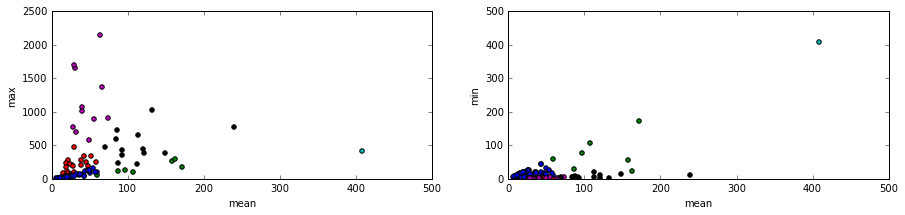

In [32]:
fig = plt.figure(figsize=(15,3))
c_list = 'rgbmkc'

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
count = 0
for label in country_stats['label'].unique():
    x = list(country_stats.ix[country_stats['label'] == label,'min'])
    y = list(country_stats.ix[country_stats['label'] == label,'max'])
    z = list(country_stats.ix[country_stats['label'] == label,'mean'])
    ax1.scatter(z, y, c=c_list[count], marker='o')
    ax2.scatter(z, x, c=c_list[count], marker='o')
    count = count+1


ax1.set_xlabel('mean')
ax1.set_ylabel('max')
ax1.set_xlim([0,500])
ax1.set_ylim([0,2500])
ax2.set_xlabel('mean')
ax2.set_ylabel('min')
ax2.set_xlim([0,500])
ax2.set_ylim([0,500]);

In [33]:
for i in range(0,6):
    print(c_list[i] + ' corresponds to:')
    print(list(country_stats[country_stats['label'] == country_stats['label'].unique()[i]].index[:5]))

r corresponds to:
['', 'Argentina', 'Australia', 'Austria', 'Belgium']
g corresponds to:
['Algeria', 'Germany, Austria, & Switzerland', 'Haiti', 'Lebanon', 'Pakistan']
b corresponds to:
['Andorra', 'Australia & New Zealand', 'Bahamas, The', 'Barbados', 'Benelux']
m corresponds to:
['Brazil', 'France', 'Germany', 'Italy', 'Japan']
k corresponds to:
['Denmark', 'Egypt', 'Ethiopia', 'Finland', 'India']
c corresponds to:
['Mongolia']


In [41]:
albums.ix[albums['country'] == 'Mongolia', ['artist','title','label','year','median price sold']]

,artist,title,label,year,median price sold
1815,The Bayan Mongol Variety Group,"Эстрадный Ансамбль ""Баян Монгол"" Чуулга",Мелодия,1980,408.07


The six groups are:

1) Red: low mean/min, middling max; uniformly cheap countries  
places where major labels release records with fewer small pressings  
e.g. Australia, Canada, Cuba, Poland, plus hybrid 'countries' like Europe

2) Green: high mean/min, low max; uniformly expensive countries  
places with only a few, sought after releases  
e.g. Haiti, Lebanon, Pakistan

3) Blue: middling mean/min, low max; uniformly mid-range countries  
places where records are slightly rarer, with local scenes of interest  
e.g. Colombia, Ghana, Jamaica, Mexico

4) Magenta: low mean, low min, high max; diversely cheaper countries,  
major labels releasing records in bulk but also smaller (private?) pressings  
e.g. US, UK, Brazil, France, Japan 

5) Black: high mean, low min, high max; diversely expensive countries  
places with both major label operations, but also local scenes of interest  
e.g. Belgium, India, South Africa, Turkey

6) Cyan: Mongolia, or specifically one record of a Soviet variety show by the Bayan Mongol Group  
this fits in best with the records in 1) so reassign Mongolia there

These are pretty neat divisions (except for the last one), so we should add these as binary variables.  
I don't agree with where some of the countries end up, but these have few data points - more data will place them in the 'correct' category.

N.B. This is a bit dodgy as we're using the test data to build the classifier, so perhaps in future we should only cluster on those in the training data.  
We also should create a more rigorous way of weeding out 'Mongolias': if there's less than a certain number of countries in a cluster, assign them to the next nearest cluster.

In [34]:
#Reassign Mongolia
country_stats.ix['Mongolia', 'label'] = country_stats.ix['Lebanon', 'label']

#Create binary variables for each label
count = 1
for label in country_stats['label'].unique():
    albums['country label ' + str(count)] = 0
    for country in country_stats[country_stats['label'] == label].index:
        albums.ix[albums['country'] == country, 'country label ' + str(count)] = 1
    count = count + 1

In [35]:
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'average rating', 'number of records', 'limited edition', 
              'reissue', 'difference to earliest version', 'difference to latest version',
              'country label 1', 'country label 2', 'country label 3', 'country label 4', 'country label 5']

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Random forest with countries added'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

Random forest with countries added gives £17.84 mean difference and 0.4017 score


This isn't as good as the binary variables.

## Genres

Genre may affect price: bebop collectors will probably pay more for originals than smooth jazz collectors, for example.

In [37]:
#Extract all the genres
genre_list = []
for genres in albums['genre'].unique():
    for genre in genres.split('; '):
        if genre not in genre_list:
            genre_list.append(genre)
            
#Create a binary variable for each genre
for genre in genre_list:
    albums['g_'+genre] = 0

#Populate the binary variable
for genres in albums['genre'].unique():
    for genre in genres.split('; '):
        albums.ix[albums['genre'] == genres, 'g_'+genre] = 1
        
#Ignore the genres with few (<10) entries
g_genre_list = []
for genre in genre_list:
    if sum(albums['g_'+genre])<10:
        albums.drop('g_'+genre, axis=1, inplace=True)
    else:
        print(genre + ': {0}, £{1:.2f}'.format(sum(albums['g_'+genre]),albums.ix[albums['g_'+genre] == 1,
                                                                                 'median price sold'].mean()))
        g_genre_list.append('g_'+genre)

Electronic: 2474, £32.80
Jazz: 23124, £35.27
Hip Hop: 365, £24.21
Stage & Screen: 1865, £51.57
Funk / Soul: 6067, £34.71
Rock: 3636, £35.45
Latin: 1763, £37.27
Folk, World, & Country: 1262, £46.08
Pop: 1131, £33.75
Classical: 388, £49.13
Non-Music: 284, £43.94
Reggae: 153, £30.66
Blues: 521, £30.02
Children's: 19, £22.49
Brass & Military: 38, £38.46


Hip hop records are invariably newer, so less expensive.  
Stage & Screen is more expensive (perhaps less popular upon initial release, at least in the realms of jazz).  
Folk, World, & Country will be pressings from more 'exotic' locations, so more expensive.  
Classical/non-music is more expensive (perhaps less popular upon initial release, at least in the realms of jazz).

Let's use some of these as features (with >100 entries)

In [38]:
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'average rating', 'number of records', 'limited edition', 
              'reissue', 'difference to earliest version', 'difference to latest version'] + c_country_list + g_genre_list

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Random forest with genres added'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

mean_diff_each_step.append(mean_diff)
score_each_step.append(score)
each_step.append('Genres')

Random forest with genres added gives £17.45 mean difference and 0.4155 score


Little difference.

## Styles

Slightly more specific categorisations, but may have a similar effect to genres.

In [39]:
albums.ix[albums['style'].isnull(),'style'] = ''

#Extract all the styles
style_list = []
for styles in albums['style'].unique():
    for style in styles.split('; '):
        if style not in style_list:
            style_list.append(style)
            
#Create a binary variable for each style
for style in style_list:
    albums['s_'+style] = 0

#Populate the binary variable
for styles in albums['style'].unique():
    for style in styles.split('; '):
        albums.ix[albums['style'] == styles, 's_'+style] = 1
        
#Ignore the styles with few (<10) entries
s_style_list = []
for style in style_list:
    if sum(albums['s_'+style])<10:
        albums.drop('s_'+style, axis=1, inplace=True)
    else:
        print(style + ': {0}, £{1:.2f}'.format(sum(albums['s_'+style]),albums.ix[albums['s_'+style] == 1, 
                                                                                 'median price sold'].mean()))
        s_style_list.append('s_'+style)

Jazz-Funk: 4587, £29.90
Instrumental: 103, £31.48
Downtempo: 216, £23.30
Jazzy Hip-Hop: 46, £32.09
Fusion: 3136, £27.98
Soundtrack: 1029, £46.82
Score: 287, £50.94
Ambient: 249, £33.81
Modal: 1343, £40.89
Funk: 1755, £32.85
Disco: 884, £23.29
Soul-Jazz: 2786, £28.06
Jazz-Rock: 1846, £35.35
Contemporary Jazz: 1371, £34.15
Psychedelic: 330, £48.71
Soul: 1016, £22.10
Afro-Cuban: 129, £29.44
Afrobeat: 490, £34.54
Abstract: 285, £45.04
Avantgarde: 546, £31.73
Prog Rock: 852, £43.80
Boogie: 21, £73.78
Rhythm & Blues: 261, £25.87
Smooth Jazz: 520, £25.19
Avant-garde Jazz: 424, £51.67
Post Bop: 1222, £33.23
: 1893, £45.13
Bossa Nova: 596, £39.55
Alternative Rock: 70, £27.53
Punk: 26, £23.47
Latin Jazz: 1329, £27.85
MPB: 227, £58.44
Space-Age: 603, £33.65
Cool Jazz: 492, £30.99
Big Band: 584, £32.31
Contemporary: 102, £49.56
African: 147, £49.20
Free Jazz: 2594, £39.91
Future Jazz: 249, £23.86
Deep House: 40, £17.25
Experimental: 1123, £41.37
Free Improvisation: 1074, £48.59
Easy Listening: 183

In [40]:
predictors = ['compilation','number for sale', 'number have', 'number of ratings', 'number of tracks',
              'number of versions', 'number on label', 'number on label for sale', 'number want', 
              'integer year', 'average rating', 'number of records', 'limited edition', 
              'reissue', 'difference to earliest version', 'difference to latest version'] + c_country_list + g_genre_list + s_style_list

#Randomly shuffle the row order
new_albums = albums.sample(frac=1)

#Generate predictions
predictions = get_random_forest_predictions(new_albums, predictors)

#Calculate
mean_diff = get_mean_diff(np.array(new_albums['median price sold']), predictions)
score = get_score(np.array(new_albums['median price sold']), predictions)

print('Random forest with styles added'
      ' gives £{0:.2f} mean difference and {1:.4f} score'.format(mean_diff,score))

mean_diff_each_step.append(mean_diff)
score_each_step.append(score)
each_step.append('Styles')

Random forest with styles added gives £17.27 mean difference and 0.4179 score


Improves mean difference a little at least.

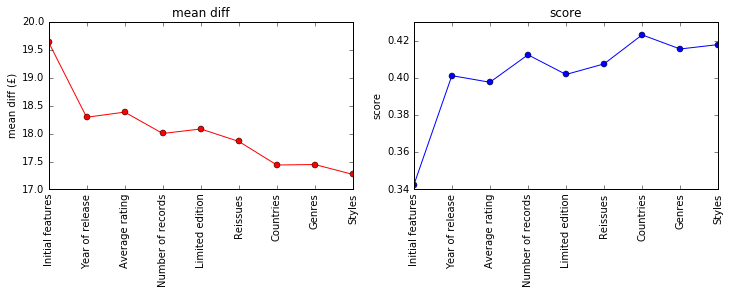

In [41]:
xticks = list(range(0,len(score_each_step)))
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(121)
ax1.plot(xticks,mean_diff_each_step,'-or')
ax1.set_title('mean diff')
ax1.set_xticks(xticks)
ax1.set_xticklabels(each_step, rotation=90)
ax1.set_ylabel('mean diff (£)')
ax2 = fig.add_subplot(122)
ax2.plot(xticks,score_each_step,'-ob')
ax2.set_title('score')
ax2.set_xticks(xticks)
ax2.set_xticklabels(each_step, rotation=90)
ax2.set_ylabel('score');

Although there's obviously some noise in both the mean difference and score associated with the random partitioning of the data into train and test sets, there's still a clear improvement in both measures as features have been added.

In [42]:
albums.to_csv('../data/interim/albums.csv',encoding='utf-8')